# Imports

Import python libraries as well as the self written FERMI library.

In [224]:
import sys, os
USER = os.environ['USER']

sys.path.append('./FERMI_2020-07/')
sys.path.append(f'/net/phase/store/users/{USER}/.local/lib/python3.9/site-packages')

import numpy as np
import xarray as xr
import pandas as pd
import h5py
from os.path import join, split
from glob import glob
from time import strftime
from imageio import imread


from scipy.ndimage.filters import median_filter 

import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import process_FERMI_2021 as pf

from tqdm.auto import tqdm

from importlib import reload
from copy import deepcopy

In [225]:
#interactive plotting
%matplotlib widget

In [369]:
def norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

# Hysteresis

## Load Data

In [388]:
#loading data
basefolder = f'/net/phase/store/users/{USER}/20209130/'
samplefolder = 'PtCoTa_76/'
scanfolder = 'H1_Hysteresis_072'#Sat_NegDelIR20uJ_012'

datafolder = join(basefolder, samplefolder, scanfolder)
extra_keys = {
    'diode_sum': 'PAM/FQPDSum',
    'IR': 'Laser/Energy1',
    'magnet': 'DPI/CoilCurrent',
    'bunches': 'bunches',
    'time': '',
}

exp = pf.get_exp_dataframe(datafolder + '_OF', keys=extra_keys)
for k in ['xgm_UH', 'xgm_SH', 'diode_sum']:
    exp[k + '_sum'] = exp[k].apply(np.sum)

exp['diode_sum_mean'] = exp.diode_sum.apply(np.mean)
exp['diode_sum_std'] = exp.diode_sum.apply(np.std)
exp['IR_mean'] = exp.IR.apply(np.mean)
exp['IR_std'] = exp.IR.apply(np.std)
exp['magnet_mean'] = exp.magnet.apply(np.mean)
exp['magnet_mean'] = exp.magnet_mean.apply(np.round, args=(3,))
exp['bunchid'] = exp.bunches.apply(lambda l: l[-1])

#exp = exp.sort_values('magnet_mean')

In [389]:
#dark image
exp_bg = pf.get_exp_dataframe(datafolder + '_BG', keys=extra_keys)
exp_bg['bunchid'] = exp.bunches.apply(lambda l: l[-1])
exp_bg = exp_bg.sort_values('time')

darkfolder = datafolder + '_BG'
darks = []
dflist = glob(darkfolder + '/**/*h5', recursive=True)
print(f'found {len(dflist)} files')
for f in dflist:
    _dark = pf.loadh5(f)[0]
    darks.append(_dark)
dark = np.mean(darks, axis = 0).astype(float)

found 3 files


## Load Data to compare

In [370]:
#loading data
basefolder = f'/net/phase/store/users/{USER}/20209130/'
samplefolder = 'PtCoTa_76/'
scanfolder = 'B1_Hysteresis_030'

datafolder = join(basefolder, samplefolder, scanfolder)
extra_keys = {
    'diode_sum': 'PAM/FQPDSum',
    'IR': 'Laser/Energy1',
    'magnet': 'DPI/CoilCurrent',
    'bunches': 'bunches',
    'time': '',
}

exp2 = pf.get_exp_dataframe(datafolder + '_OF', keys=extra_keys)
for k in ['xgm_UH', 'xgm_SH', 'diode_sum']:
    exp2[k + '_sum'] = exp2[k].apply(np.sum)

exp2['magnet_mean'] = exp2.magnet.apply(np.mean)
exp2['magnet_mean'] = exp2.magnet_mean.apply(np.round, args=(3,))


#dark image
exp_bg2 = pf.get_exp_dataframe(datafolder + '_BG', keys=extra_keys)
exp_bg2['bunchid'] = exp2.bunches.apply(lambda l: l[-1])
exp_bg2 = exp_bg2.sort_values('time')

darkfolder = datafolder + '_BG'
darks2 = []
dflist = glob(darkfolder + '/**/*h5', recursive=True)
print(f'found {len(dflist)} files')
for f in dflist:
    _dark = pf.loadh5(f)[0]
    darks2.append(_dark)
dark2 = np.mean(darks2, axis = 0).astype(float)

found 5 files


In [371]:
#loading data
basefolder = f'/net/phase/store/users/{USER}/20209130/'
samplefolder = 'PtCoTa_76/'
scanfolder = 'I1_Hysteresis_070'

datafolder = join(basefolder, samplefolder, scanfolder)
extra_keys = {
    'diode_sum': 'PAM/FQPDSum',
    'IR': 'Laser/Energy1',
    'magnet': 'DPI/CoilCurrent',
    'bunches': 'bunches',
    'time': '',
}

exp3 = pf.get_exp_dataframe(datafolder + '_OF', keys=extra_keys)
for k in ['xgm_UH', 'xgm_SH', 'diode_sum']:
    exp3[k + '_sum'] = exp3[k].apply(np.sum)

exp3['magnet_mean'] = exp3.magnet.apply(np.mean)
exp3['magnet_mean'] = exp3.magnet_mean.apply(np.round, args=(3,))

#dark image
exp_bg3 = pf.get_exp_dataframe(datafolder + '_BG', keys=extra_keys)
exp_bg3['bunchid'] = exp3.bunches.apply(lambda l: l[-1])
exp_bg3 = exp_bg3.sort_values('time')

darkfolder = datafolder + '_BG'
darks3 = []
dflist = glob(darkfolder + '/**/*h5', recursive=True)
print(f'found {len(dflist)} files')
for f in dflist:
    _dark = pf.loadh5(f)[0]
    darks3.append(_dark)
dark3= np.mean(darks3, axis = 0).astype(float)

found 3 files


## Integrate

In [390]:
total_intensities=np.empty(len(exp2))
for i in range(len(exp2)):
    imi, _ = pf.loadh5(exp2.iloc[i]['filename'], extra_keys=['alignz', 'PAM/FQPDSum'])
    total_intensities[i] = np.sum(imi[:60, 110:200]) # + np.sum(imi[:140, 505:650])
    
total_intensity2=np.empty(len(exp3))
for i in range(len(exp3)):
    imi, _ = pf.loadh5(exp3.iloc[i]['filename'], extra_keys=['alignz', 'PAM/FQPDSum'])
    total_intensity2[i] = np.sum(imi[:60, 110:200]) # + np.sum(imi[:140, 505:650])
    
total_intensity=np.empty(len(exp))
for i in range(len(exp)):
    imi, _ = pf.loadh5(exp.iloc[i]['filename'], extra_keys=['alignz', 'PAM/FQPDSum'])
    total_intensity[i] = np.sum(imi[:140, 250:370]) + np.sum(imi[:140, 505:650])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
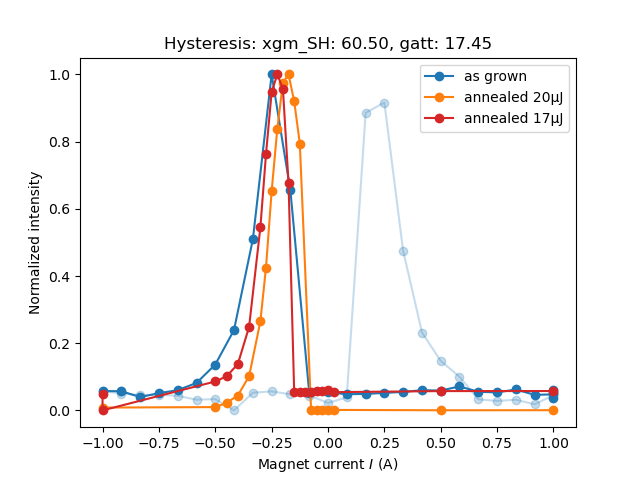

In [391]:
lim2 = len(exp2) // 2 + 1

fig, ax = plt.subplots()
ax.set_xlabel('Magnet current $I$ (A)')
ax.set_ylabel('Normalized intensity')
ax.set_title(f'Hysteresis: xgm_SH: {exp.xgm_SH.mean().mean():.2f}, gatt: {exp.gatt.mean():.2f}')#{exp.IR_mean.mean():.2f}µJ')
ax.plot(exp2['magnet_mean'][:lim2+1], norm(total_intensities)[:lim2+1], 'o-', c = 'tab:blue', label = 'as grown')
ax.plot(exp2['magnet_mean'][lim2-1:], norm(total_intensities)[lim2-1:], 'o-', c = 'tab:blue', alpha = .25)
ax.plot(np.append(exp3['magnet_mean'][:19], exp3['magnet_mean'][24]), np.append(norm(total_intensity2)[:19], norm(total_intensity2)[24]),
        'o-', c = 'tab:orange', label = 'annealed 20µJ')
ax.plot(exp['magnet_mean'], norm(total_intensity), 'o-', c = 'tab:red', label = 'annealed 17µJ')
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
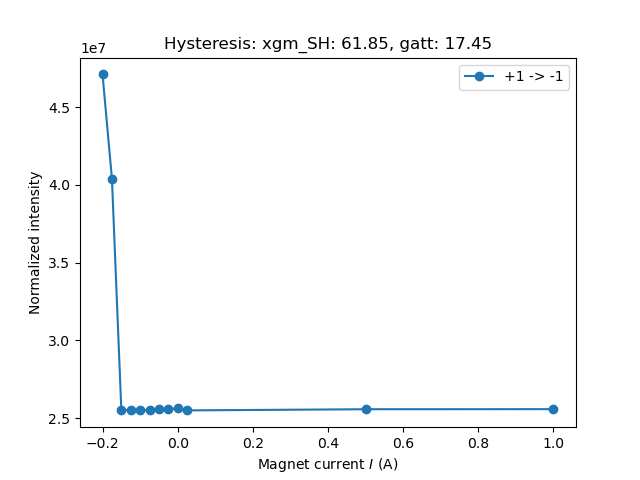

In [365]:
lim = len(exp) // 2 + 1
lim2 = len(exp2) // 2 + 1
lim = 19

fig, ax = plt.subplots()
ax.set_xlabel('Magnet current $I$ (A)')
ax.set_ylabel('Normalized intensity')
ax.set_title(f'Hysteresis: xgm_SH: {exp.xgm_SH.mean().mean():.2f}, gatt: {exp.gatt.mean():.2f}')#{exp.IR_mean.mean():.2f}µJ')
# ax.plot(exp2['magnet_mean'][:lim2], total_intensities[:lim2], 'o-', c = 'tab:blue', label = 'as grown')
# ax.plot(exp2['magnet_mean'][lim2-1:], total_intensities[lim2-1:], 'o-', c = 'tab:blue', alpha = .25)
ax.plot(exp['magnet_mean'], total_intensity, 'o-',label = '+1 -> -1')
#ax.plot(exp['magnet_mean'][lim-1:], total_intensity[lim-1:], 'o-', label = '-1 -> +1')
# ax.plot(exp['magnet_mean'][:lim], total_intensity[:lim]/np.max(total_intensity), 'o-')#, label = f'IR {exp.IR_mean.mean():.1f}µJ')
ax.legend()

In [334]:
exp['magnet_mean']

0     1.000
1     0.500
2     0.025
3    -0.000
4    -0.025
5    -0.050
6    -0.075
7    -0.125
8    -0.150
9    -0.175
10   -0.200
11   -0.225
12   -0.250
13   -0.275
14   -0.300
15   -0.350
16   -0.400
17   -0.450
18   -0.500
19    1.000
20   -0.500
21   -0.025
Name: magnet_mean, dtype: float64